<a href="https://colab.research.google.com/github/luanchenhui/-/blob/master/detect_traintestsplit_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

在训练阶段，使用train_test_split进行k交叉验证，验证模型的准确性及适用范围。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# loss function
import keras.backend as K
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 2
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1-y_true) * sqaure_pred + (y_true) * margin_square)
print('Finished!')

Using TensorFlow backend.


Finished!


In [0]:
import cv2
import PIL.Image as Image
import numpy as np
import xml.dom.minidom as minidom
from random import sample,choice
from keras.utils import Sequence
# from keras.applications.vgg19 import preprocess_input
from imgaug import augmenters as iaa
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import ImageEnhance
import imgaug as ia

'''
批量产生训练集数据；
没有生成训练集和测试集。
'''
class TrainingSequenceData(Sequence):
    def __init__(self, files, ROI=[118, 103, 388, 349], batch_size = 32):
        '''
        :param filenames:装有待测图像的文件名的列表
        :param batch_size: 每批的图像样本个数
        '''
        # self.filenames = filenames
        self.batch_size = batch_size
        self.files = files
        self.image_file_pairs, self.labels = self.siamese_pairs()
        self.ROI = ROI
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        self.normal_seq = iaa.Sequential([
            # iaa.Fliplr(0.5), # horizontal flips
            # iaa.Flipud(0.5),
            
            iaa.Sometimes(0.5,
                          iaa.GaussianBlur(sigma=(0, 1))
                          ),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            sometimes(iaa.Crop(percent=(0, 0.1))),
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-15, 15),
                shear=(-8, 8),
                order=[0, 1],
                cval=(0, 255),
                mode=ia.ALL
            )),
            iaa.SomeOf((0, 5),
                       [
                           # Convert some images into their superpixel representation,
                           # sample between 20 and 200 superpixels per image, but do
                           # not replace all superpixels with their average, only
                           # some of them (p_replace).
                           # 超分辨率
                           sometimes(
                               iaa.Superpixels(
                                   p_replace=(0, 0.3),
                                   n_segments=(20, 200)
                               )
                           ),

                          #  Blur each image with varying strength using
                          #  gaussian blur (sigma between 0 and 3.0),
                          #  average/uniform blur (kernel size between 2x2 and 7x7)
                          #  median blur (kernel size between 3x3 and 11x11).
                          #  模糊
                           iaa.OneOf([
                               iaa.GaussianBlur((0, 2.0)),
                               iaa.AverageBlur(k=(2, 4)),
                               iaa.MedianBlur(k=(3, 5)),
                           ]),

        #                    # Sharpen each image, overlay the result with the original
        #                    # image using an alpha between 0 (no sharpening) and 1
        #                    # (full sharpening effect).
                           # 锐化、亮度
                           iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5)),

        #                    # Same as sharpen, but for an embossing effect.
                           # 浮雕
                           iaa.Emboss(alpha=(0, 1.0), strength=(0, 0.5)),

        #                    # Search in some images either for all edges or for
        #                    # directed edges. These edges are then marked in a black
        #                    # and white image and overlayed with the original image
        #                    # using an alpha of 0 to 0.7.
                           # 边缘检测
                           sometimes(iaa.OneOf([
                               iaa.EdgeDetect(alpha=(0, 0.3)),
                               iaa.DirectedEdgeDetect(
                                   alpha=(0, 0.7), direction=(0.0, 1.0)
                               ),
                           ])),
            # 颜色通道偏移
                           iaa.Add((-10, 10), per_channel=0.5),

                           # Change brightness of images (50-150% of original value).
                           # 亮度
                           iaa.Multiply((0.7, 1.3), per_channel=0.5),

                           # Improve or worsen the contrast of images.
                           # 对比度
                           iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
                          #  到这里都没问题

                           # Convert each image to grayscale and then overlay the
                           # result with the original with random alpha. I.e. remove
                           # colors with varying strengths.
                          #  # 灰度
                          #  iaa.Grayscale(alpha=(0.0, 1.0)),

                           # In some images move pixels locally around (with random
                           # strengths).
                           # 弹性转换
                           sometimes(
                               iaa.ElasticTransformation(alpha=(0.5, 1.5), sigma=0.25)
                           ),

                           # In some images distort local areas with varying strength.
                           # 分段仿射变换
                           sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.03)))


        # ], random_order=True)])
        ], random_order=True)])

    def __len__(self):
        '''
        注：需要将len（filenames）做修改，改成组合的样本对的个数。
        :return:
        '''
        return int(len(self.image_file_pairs)/self.batch_size)

    def __getitem__(self, idx):
        '''
        迭代器，返回每批图像对的array和标签
        :param idx:
        :return:
        '''
        self.image_file_pairs, self.labels = self.siamese_pairs()

        batch_x = self.image_file_pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        a = []
        b = []
        c = []
        for i in range(len(batch_x)):
            a.append(self.read_im(batch_x[i][0]))
            b.append(self.read_im(batch_x[i][1]))
            c.append(batch_y[i])

        # X_train, X_test, y_train, y_test = train_test_split(p, c,
        #                                                     test_size=0.1, random_state=42)

        a = np.array(a).astype('float32') / 255
        b = np.array(b).astype('float32') / 255
        c = np.array(c)

        return [a, b], c
        # return np.array([a,b]), c


    def file_id_mapping(self):
        '''
        为每个图像标注正常样本和异常样本；
        :return: 文件 加 标签 的 字典
        '''
        files_id_mapping = {f: 'normal' if f.split('/')[7].split('_')[0] == 'OK' else 'defect' for f in self.filenames}
        return files_id_mapping


    def siamese_pairs(self):
        '''
        生成孪生样本对；
        :return:
        '''
        image_file_pairs = []
        labels = []

        image_files = self.files
        reference_files = []
        defect_files = []
        for f in image_files:
          if f.split('/')[6] == 'ok':
            reference_files.append(f)
          else:
            defect_files.append(f)

        
        # reference_files = glob('/content/drive/My Drive/MyProject/data2/train/OK*/*.bmp')
        # defect_files = glob('/content/drive/My Drive/MyProject/data2/train/NG*/*.bmp')


        np.random.shuffle(reference_files)
        np.random.shuffle(defect_files)

        avg = len(reference_files) / float(2)
        out = []
        last = 0.0
        while last < len(reference_files):
            out.append(reference_files[int(last):int(last + avg)])
            last += avg

        # normals0 = out[0]
        # normals1 = out[1]
        normals0 = reference_files
        np.random.shuffle(reference_files)
        normals1 = reference_files

        for num in range(16):
            for i in range(min(len(normals0), len(normals1), len(defect_files))):

                    image_file_pairs.append([normals0[(num + 1) * int(len(normals0) / 16)],
                                             normals1[i]])
                    labels.append(0)

                    image_file_pairs.append([normals0[(num + 1) * int(len(normals0) / 16)],
                                             defect_files[i]])
                    labels.append(1)


        return image_file_pairs, labels




    def read_im(self, im):
        '''
        使用PIL的图像增强脚本进行图像增强。
        :return: img
        '''
        image = Image.open(im)
#         # 亮度增强
#         enh_bri = ImageEnhance.Brightness(image)
#         brightness = np.random.randn()
#         image_brightened = enh_bri.enhance(brightness)

#         # 色度增强
#         enh_col = ImageEnhance.Color(image_brightened)
#         color = np.random.randn()
#         image_colored = enh_col.enhance(color)

        # 对比度增强
#         enh_con = ImageEnhance.Contrast(image)
#         contrast = np.random.randn()
#         image_contrasted = enh_con.enhance(contrast)

#         # 锐度增强
#         enh_sha = ImageEnhance.Sharpness(image_contrasted)
#         sharpness = np.random.randn()
#         image_sharped = enh_sha.enhance(sharpness)
        image = image.crop((self.ROI[0], self.ROI[1], self.ROI[2], self.ROI[3]))
        image_sharped = image
        image_sharped = np.array(image_sharped)
        image_sharped = self.normal_seq.augment_image(image_sharped)
        image_sharped = image_sharped.reshape([image_sharped.shape[0], image_sharped.shape[1], 1])
        return image_sharped


In [4]:
from glob import glob
filenames = glob('/content/drive/My Drive/detection/data/ok*/*.bmp')
# files_id_mapping = {f: 'normal' if f.split('\\')[1] == 'Reference' else 'defect' for f in filenames}

a = filenames[0]
a
a.split('/')[6]
im = cv2.imread(a)
print(im.shape)
h, w, _ = im.shape
print(im.shape)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(im.shape)

np.array(Image.open(a)).shape

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)


(480, 640)

In [5]:
    def siamese_pairs(files):
        '''
        生成孪生样本对；
        :return:
        '''
        image_file_pairs = []
        labels = []

        image_files = files
        reference_files = []
        defect_files = []
        for f in image_files:
          if f.split('/')[6] == 'ok':
            reference_files.append(f)
          else:
            defect_files.append(f)

        
        # reference_files = glob('/content/drive/My Drive/MyProject/data2/train/OK*/*.bmp')
        # defect_files = glob('/content/drive/My Drive/MyProject/data2/train/NG*/*.bmp')


        np.random.shuffle(reference_files)
        np.random.shuffle(defect_files)

        avg = len(reference_files) / float(2)
        out = []
        last = 0.0
        while last < len(reference_files):
            out.append(reference_files[int(last):int(last + avg)])
            last += avg

        # normals0 = out[0]
        # normals1 = out[1]
        normals0 = reference_files
        np.random.shuffle(reference_files)
        normals1 = reference_files
        print(len(normals0), len(normals1), len(defect_files))

        for num in range(19):
            for i in range(min(len(normals0), len(normals1), len(defect_files))):

                    image_file_pairs.append([normals0[(num + 1) * int(len(normals0) / 19)],
                                             normals1[i]])
                    labels.append(0)

                    image_file_pairs.append([normals0[(num + 1) * int(len(normals0) / 19)],
                                             defect_files[i]])
                    labels.append(1)


        return image_file_pairs, labels
    
    files = glob('/content/drive/My Drive/detection/data/*/*.bmp')
    a, b = siamese_pairs(files)
    len(b)


26 26 20


760

In [0]:

from keras import regularizers
from keras.optimizers import Adam, RMSprop
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, \
    Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape, Dropout
from keras.models import Model, Sequential
import keras.backend as K

# from contrastiveLoss import *
'''
更改模型，在scnn1网络基础上，更改头网络，更改为论文中使用的相似度度量l2范数；
'''
img_shape = (246, 270, 1)
kernel_size = (3, 3)
pool_size = (2, 2)
epochs = 20
batch_size = 256
nb_filters = 32
img_rows, img_cols = 100, 100
if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:
    shape_ord = (img_rows, img_cols, 1)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

# def subblock(x,filter,**kwargs):
#     # x = BatchNormalization()(x)
#     y = x
#     # reduce the number of features to 'filter'
#     y = Conv2D(filter, (1,1), activation='relu',**kwargs)(y)
#     # y = BatchNormalization()(y)
#     # extend the feature field
#     y = Conv2D(filter, (3,3), activation='relu',**kwargs)(y)
#     # y = BatchNormalization()(y)
#     # no activation # restore the number of original features
#     y = Conv2D(K.int_shape(x)[-1],(1,1),**kwargs)(y)
#     # add the bypass connection
#     y = Add()([x,y])
#     y = Activation('relu')(y)
#     return y

# def build_model(lr, l2, activation='sigmoid'):
#     ############
#     # Branch Model
#     ############
#     regul = regularizers.l2(l2)
#     optim = Adam(lr=lr)
#     kwargs = {'padding':'same', 'kernel_regularizer':regul}

#     inp = Input(shape=img_shape) # (64, 64, 3)
#     x = Conv2D(32, (3, 3), strides=1, activation='relu', **kwargs)(inp)
#     for _ in range(2):
#         # x = BatchNormalization()(x)
#         x = Conv2D(16, (5, 5), activation='relu', **kwargs)(x)

#     # x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 48x48x64
#     # x = BatchNormalization()(x)
#     x = Conv2D(32, (3, 3), activation='relu', **kwargs)(x)  # 48x48x128
    
#     for _ in range(2):
#       x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 48x48x64 
#       x = subblock(x, 32, **kwargs)
      
      

#     # x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 24x24x128
#     # x = BatchNormalization()(x)
#     # x = Conv2D(256, (1, 1), activation='relu', **kwargs)(x)  # 24x24x256
#     # for _ in range(4): x = subblock(x, 64, **kwargs)

#     x = GlobalMaxPooling2D()(x)  # 512
#     # x = Flatten(name='Flatten')(x)

#     branch_model = Model(inp, x)

#     ########################
#     # HEAD MODEL
#     ########################

#     inp_h = Input(shape=branch_model.output_shape[1:])
#     x = Dropout(0.5, name='Drop1')(inp_h)
#     x = Dense(128, name='Dense1')(x)
#     x = Dropout(0.5, name='Drop2')(x)
    # x = Dense(32, name='Dense2')(x)
    # head_model = Model(inp_h, x)

    # ########################
    # # SIAMESE NEURAL NETWORK
    # ########################

    # # Complete model is constructed by calling the branch model on each input image,
    # # and then the head model on the resulting 512-vectors.
    # img_a = Input(shape=img_shape)
    # img_b = Input(shape=img_shape)
    # xa = branch_model(img_a)
    # xb = branch_model(img_b)
    # ha = head_model(xa)
    # hb = head_model(xb)
    # distance = Lambda(euclidean_distance,
    #                   output_shape=eucl_dist_output_shape)([ha, hb])


    # model = Model([img_a, img_b], distance)
    # model.compile(loss=contrastive_loss, optimizer=optim, metrics=[accuracy, 'mae'])
    # return model, branch_model

In [0]:
def subblock(x,filter,**kwargs):
    x = BatchNormalization()(x)
    y = x
    # reduce the number of features to 'filter'
    y = Conv2D(filter,(1,1),activation='relu',**kwargs)(y)
    y = BatchNormalization()(y)
    # extend the feature field
    y = Conv2D(filter,(3,3),activation='relu',**kwargs)(y)
    y = BatchNormalization()(y)
    # no activation # restore the number of original features
    y = Conv2D(K.int_shape(x)[-1],(1,1),**kwargs)(y)
    # add the bypass connection
    y = Add()([x,y])
    y = Activation('relu')(y)
    return y
# def subblock(x, filter, **kwargs):
#     x = BatchNormalization()(x)
#     y = x
#     y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # Reduce the number of features to 'filter'
#     y = BatchNormalization()(y)
#     y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # Extend the feature field
#     y = BatchNormalization()(y)
#     y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
#     y = Add()([x,y]) # Add the bypass connection
#     y = Activation('relu')(y)
#     return y

def build_model(lr, l2, activation="sigmoid"):
    ##############
    # BRANCH MODEL
    ##############
    regul = regularizers.l2(l2)
    optim = Adam(lr=lr)
    kwargs = {'padding': 'same', 'kernel_regularizer': regul}

    inp = Input(shape=img_shape)  # 384x384x1
    x = Conv2D(64, (9, 9), strides=2, activation='relu', **kwargs)(inp) # 192*192*64

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1, 1), activation='relu', **kwargs)(x)  # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    # x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 24x24x128
    # # x = BatchNormalization()(x)
    # x = Conv2D(256, (1, 1), activation='relu', **kwargs)(x)  # 24x24x256
    # for _ in range(4): x = subblock(x, 64, **kwargs)

    # x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 12x12x256
    # # x = BatchNormalization()(x)
    # x = Conv2D(384, (1, 1), activation='relu', **kwargs)(x)  # 12x12x384
    # for _ in range(4): x = subblock(x, 96, **kwargs)

    # x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1, 1), activation='relu', **kwargs)(x)  # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)

    x = GlobalMaxPooling2D()(x)  # 512
    x = Dropout(0.5)(x)
    branch_model = Model(inp, x)

    ############
    # HEAD MODEL
    ############

    inp_h = Input(shape=branch_model.output_shape[1:])
    x = Dropout(0.5, name='Drop1')(inp_h)
    x = Dense(128, name='Dense1')(x)
    x = Dropout(0.5, name='Drop2')(x)
    x = Dense(32, name='Dense2')(x)
    head_model = Model(inp_h, x)

    ########################
    # SIAMESE NEURAL NETWORK
    ########################

    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a)
    xb = branch_model(img_b)
    ha = head_model(xa)
    hb = head_model(xb)
    distance = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)([ha, hb])


    model = Model([img_a, img_b], distance)
    model.compile(loss=contrastive_loss, optimizer=optim, metrics=[accuracy, 'mae'])
    return model, branch_model, head_model

In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint('tm-snn_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks_list = [reduce_lr, checkpoint]

加入train_test_split函数，对训练集和测试集进行划分。
(1).加入指标衡量函数；


In [0]:
from sklearn.metrics import roc_curve, auc
def calculate_fpr_tpr_f1score_accuracy(y_true, y_pred):
  '''
  y_true 和 y_pred均是ndarray类型。
  '''
  y_true = y_true.flatten()
  y_pred = y_pred.flatten()

  Tp = 0
  Fp = 0
  Tn = 0
  Fn = 0

  for label, pred in zip(y_true, y_pred):
      if (label == 1) and (pred == 1):
          Tp = Tp+1
      elif (label == 0) and (pred == 1):
          Fp = Fp + 1
      elif (label == 0) and (pred == 0):
          Tn = Tn + 1
      elif (label == 1) and (pred == 0):
          Fn = Fn + 1
      else:
          print('something weird with labels')
          return -1
          # sys.exit()

  #calculate precision, recall, accuracy, f1
  #it's possible for division by zero in some of these cases, so do a try/except
  try: precision = Tp/(Tp + Fp)                           
  except: precision = 0
    
  try: recall = Tp/(Tp + Fn)                              
  except: recall = 0
    
  try: accuracy = (Tn + Tp)/(Tn+Tp+Fn+Fp)                 
  except: accuracy = 0
    
  try: f1Score = 2*precision*recall/(precision + recall)  
  except: f1Score = 0
    
  try: fpr = Fp/(Fp + Tn)                                 
  except: fpr = 0
    
  try: tpr = Tp/(Tp + Fn)                                 
  except: tpr = 0

  # fpr, tpr, threshold = roc_curve(y_true, y_pred) ###计算真正率和假正率
    
  return (fpr, tpr, f1Score, accuracy)
  

import pandas as pd
from sklearn.metrics import roc_curve, auc

def calculate_roc(y_true, prob):
    #calculate the ROC with a probability step size of 0.01
    thresh_delta = 0.01
    thresh_values = [i*thresh_delta for i in range(0,int(1/thresh_delta)+1)]

    stats = []
    for thresh in thresh_values:
        y_pred = (prob > thresh).astype(int)
        fpr, tpr, f1Score, accuracy = calculate_fpr_tpr_f1score_accuracy(y_true, y_pred)
        stats.append([thresh, fpr, tpr, f1Score, accuracy])

    columns = ['thresh', 'fpr', 'tpr', 'f1Score', 'accuracy']
    roc_df = pd.DataFrame(stats, columns=columns)

    return roc_df


（2）定义一个函数来计算ROC曲线；
（3）定义一个函数来绘制ROC曲线；

In [0]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

def calculate_roc(y_true, prob):
    #calculate the ROC with a probability step size of 0.01
    thresh_delta = 0.01
    thresh_values = [i*thresh_delta for i in range(0,int(1/thresh_delta)+1)]

    stats = []
    for thresh in thresh_values:
        y_pred = (prob > thresh).astype(int)
        # y_pred = (prob < thresh).astype(int)
        fpr, tpr, f1Score, accuracy = calculate_fpr_tpr_f1score_accuracy(y_true, y_pred)
        stats.append([thresh, fpr, tpr, f1Score, accuracy])

    columns = ['thresh', 'fpr', 'tpr', 'f1Score', 'accuracy']
    roc_df = pd.DataFrame(stats, columns=columns)

    return roc_df

def plot_roc(roc_df):
    def update_annot(ind):
        x,y = line.get_data()
        annot.xy = (x[ind['ind'][0]], y[ind['ind'][0]])
        text = '{}'.format(' '.join([thresholds[n] for n in ind['ind']]))
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    #convert "thresholds" to string 
    thresholds = roc_df[0]['thresh']
    thresholds = [('%.3f' % thresh) for thresh in thresholds]
    
    #define the annotation 
    fig, ax = plt.subplots(figsize=(8,6))
    annot = ax.annotate('', xy=(0,0), xytext=(-20,20),textcoords='offset points', bbox=dict(boxstyle='round', fc='w'), arrowprops=dict(arrowstyle='->'))
    annot.set_visible(False)

    #plot all ROC curves 
    #also calculate the average ROC curve
    roc_avg = roc_df[0].copy(deep=True)
    roc_avg[:] = 0
    for ind, df in enumerate(roc_df):
        roc_auc = auc(df['fpr'], df['tpr'])  ###计算auc的值
        plt.plot(df['fpr'], df['tpr'], '.-', label=('run %i') % int(ind+1) + 'ROC(area = %0.2f)' % roc_auc)
        roc_avg = roc_avg + df

    #get the average ROC
    roc_avg = roc_avg/(ind+1)

    #plot average of all ROC curves
    roc_auc = auc(roc_avg['fpr'], roc_avg['tpr'])  ###计算auc的值
    line, = plt.plot(roc_avg['fpr'], roc_avg['tpr'], '*-', label='average ROC(area = %0.2f)' % roc_auc)
    plt.legend(loc=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for Multiple Cross Validations')
    fig.canvas.mpl_connect('motion_notify_event', hover)

    plt.tight_layout()
    plt.show()

    return roc_avg

In [12]:
model, branch_model, head_model = build_model(64e-5, 0)

model.summary(), model.layers[2].summary()

W0826 10:38:11.777705 139959362385792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 10:38:11.779039 139959362385792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 10:38:11.782165 139959362385792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 10:38:11.797687 139959362385792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0826 10:38:11.813068 139959362385792 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 246, 270, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 246, 270, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512)          1502336     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 32)           69792       model_1[1][0]                    
          

(None, None)

定义一个函数来训练和测试模型，并反馈测试数据及模型。

In [0]:
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image


def train_model_with_test_data(X_train, y_train, X_test, y_test, idx, do_plot):
  # 训练模型
  print('====================================================')
  print('Loading data...')
  print('Train the model...')
  all_gen = TrainingSequenceData(X_train, ROI=[118, 103, 388, 349], batch_size=32)
  model, branch_model, head_model = build_model(64e-5, 0)
  # model.load_weights('/content/drive/My Drive/MyProject/oneshot-scnn-detect44444.h5')
  history = model.fit_generator(all_gen,  epochs=80, 
                              verbose=1,
                              callbacks=callbacks_list,
                              steps_per_epoch=20)
  model.save('/content/drive/My Drive/detection/traintestsplit{}_v4.h5'.format(str(idx)))
  # model.load_weights('/content/drive/My Drive/MyProject/traintestsplit{}_v5.h5'.format(str(idx)))
  print('Model has been saved..')

  def load_image(filename, ROI=[118, 103, 388, 349]):
    im = np.array(Image.open(filename).crop((ROI[0], ROI[1], ROI[2], ROI[3]))).astype('float32')/255
    im = im.reshape([1,im.shape[0],im.shape[1],1])
    return im

  template = load_image("/content/drive/My Drive/detection/data/ok/ok0.bmp")

  distance_list = []
  for i in range(len(X_test)):
      distance = model.predict([load_image(X_test[i]), template])
      distance_list.append(distance)
  
  distance_list = np.array(distance_list)
  y_test = np.array(y_test)

  if do_plot:
    
    plt.subplot(2,1,1)
    plt.title('Test')
    plt.plot(y_test, marker='*',ls='--',c='b',alpha=0.5)
    plt.legend(['Label'])
    plt.subplot(2,1,2)
    plt.plot(np.array(distance_list).reshape([distance_list.shape[0],1]), marker='*',ls='--',c='b',alpha=0.5)
    plt.legend(['Predicted'])
    plt.show()

  roc_df = calculate_roc(y_test.flatten(), distance_list.flatten())

  return (model, roc_df)
  


In [0]:
# files = glob(('/content/drive/My Drive/detection/data/*/*.bmp'))
# X_train, X_test, y_train, y_test = train_test_split(files, y,test_size=0.3)
# len(files), len(X_test)

定义一个函数来训练模型，并在训练中加入k折叠法交叉验证，对训练结果进行验证。

Loading data...
Train the model...


W0826 10:38:28.382451 139959362385792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/80
20/20 [==============================] - 37s 2s/step - loss: 10592.0835 - accuracy: 0.5000 - mean_absolute_error: 112.5206


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/80
20/20 [==============================] - 26s 1s/step - loss: 312.9348 - accuracy: 0.5000 - mean_absolute_error: 22.7983
Epoch 3/80
20/20 [==============================] - 26s 1s/step - loss: 39.0256 - accuracy: 0.5000 - mean_absolute_error: 7.9737
Epoch 4/80
20/20 [==============================] - 27s 1s/step - loss: 9.9644 - accuracy: 0.5000 - mean_absolute_error: 3.9431
Epoch 5/80
20/20 [==============================] - 28s 1s/step - loss: 3.9538 - accuracy: 0.5000 - mean_absolute_error: 2.2601
Epoch 6/80
20/20 [==============================] - 26s 1s/step - loss: 2.0340 - accuracy: 0.5000 - mean_absolute_error: 1.5165
Epoch 7/80
20/20 [==============================] - 26s 1s/step - loss: 1.3493 - accuracy: 0.5000 - mean_absolute_error: 1.0138
Epoch 8/80
20/20 [==============================] - 26s 1s/step - loss: 1.2124 - accuracy: 0.5016 - mean_absolute_error: 0.8918
Epoch 9/80
20/20 [==============================] - 29s 1s/step - loss: 1.0407 - accuracy: 0.5016 - 

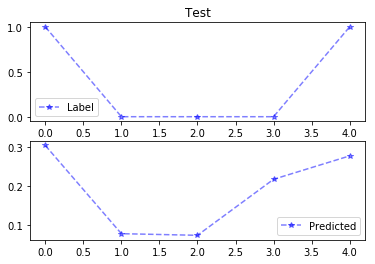

Loading data...
Train the model...
Epoch 1/80
20/20 [==============================] - 35s 2s/step - loss: 8925.8514 - accuracy: 0.5000 - mean_absolute_error: 107.0314
Epoch 2/80
20/20 [==============================] - 28s 1s/step - loss: 243.1354 - accuracy: 0.5000 - mean_absolute_error: 20.3571
Epoch 3/80
20/20 [==============================] - 27s 1s/step - loss: 29.9021 - accuracy: 0.5000 - mean_absolute_error: 6.8025
Epoch 4/80
20/20 [==============================] - 26s 1s/step - loss: 6.7884 - accuracy: 0.5000 - mean_absolute_error: 3.0636
Epoch 5/80
20/20 [==============================] - 26s 1s/step - loss: 2.6287 - accuracy: 0.5000 - mean_absolute_error: 1.6957
Epoch 6/80
20/20 [==============================] - 28s 1s/step - loss: 1.3476 - accuracy: 0.5000 - mean_absolute_error: 1.0210
Epoch 7/80
20/20 [==============================] - 29s 1s/step - loss: 1.3321 - accuracy: 0.4969 - mean_absolute_error: 0.8647
Epoch 8/80
20/20 [==============================] - 27s 1s/s

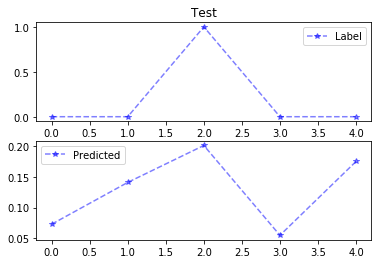

Loading data...
Train the model...
Epoch 1/80
20/20 [==============================] - 38s 2s/step - loss: 11250.3033 - accuracy: 0.5000 - mean_absolute_error: 115.2033
Epoch 2/80
20/20 [==============================] - 25s 1s/step - loss: 341.3678 - accuracy: 0.5000 - mean_absolute_error: 24.1881
Epoch 3/80
20/20 [==============================] - 28s 1s/step - loss: 51.8875 - accuracy: 0.5000 - mean_absolute_error: 9.3968
Epoch 4/80
20/20 [==============================] - 29s 1s/step - loss: 14.8982 - accuracy: 0.5000 - mean_absolute_error: 4.8880
Epoch 5/80
20/20 [==============================] - 27s 1s/step - loss: 5.6061 - accuracy: 0.5000 - mean_absolute_error: 2.7841
Epoch 6/80
20/20 [==============================] - 27s 1s/step - loss: 2.6504 - accuracy: 0.5000 - mean_absolute_error: 1.8115
Epoch 7/80
20/20 [==============================] - 26s 1s/step - loss: 1.7714 - accuracy: 0.5000 - mean_absolute_error: 1.2486
Epoch 8/80
20/20 [==============================] - 28s 1s

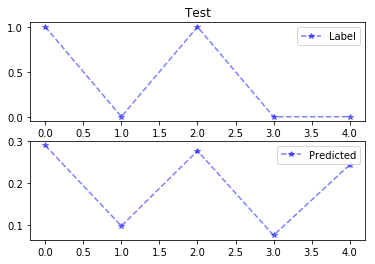

Loading data...
Train the model...
Epoch 1/80
20/20 [==============================] - 41s 2s/step - loss: 10149.1414 - accuracy: 0.5000 - mean_absolute_error: 111.3952
Epoch 2/80
20/20 [==============================] - 28s 1s/step - loss: 285.5824 - accuracy: 0.5000 - mean_absolute_error: 22.1063
Epoch 3/80
20/20 [==============================] - 26s 1s/step - loss: 37.4065 - accuracy: 0.5000 - mean_absolute_error: 7.8026
Epoch 4/80
20/20 [==============================] - 28s 1s/step - loss: 9.4516 - accuracy: 0.5000 - mean_absolute_error: 3.7574
Epoch 5/80
20/20 [==============================] - 27s 1s/step - loss: 4.0970 - accuracy: 0.5000 - mean_absolute_error: 2.2737
Epoch 6/80
20/20 [==============================] - 27s 1s/step - loss: 2.1755 - accuracy: 0.5000 - mean_absolute_error: 1.4584
Epoch 7/80
20/20 [==============================] - 29s 1s/step - loss: 1.2758 - accuracy: 0.5000 - mean_absolute_error: 0.9828
Epoch 8/80
20/20 [==============================] - 29s 1s/

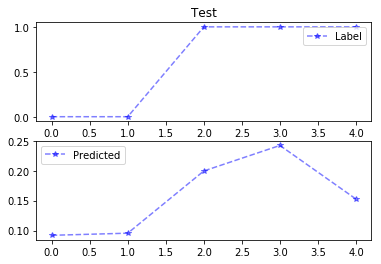

Loading data...
Train the model...
Epoch 1/80
20/20 [==============================] - 42s 2s/step - loss: 10709.7780 - accuracy: 0.5000 - mean_absolute_error: 115.6461
Epoch 2/80
20/20 [==============================] - 25s 1s/step - loss: 348.8232 - accuracy: 0.5000 - mean_absolute_error: 24.7598
Epoch 3/80
20/20 [==============================] - 27s 1s/step - loss: 44.3461 - accuracy: 0.5000 - mean_absolute_error: 8.6129
Epoch 4/80
20/20 [==============================] - 28s 1s/step - loss: 10.0111 - accuracy: 0.5000 - mean_absolute_error: 3.9047
Epoch 5/80
20/20 [==============================] - 27s 1s/step - loss: 3.2883 - accuracy: 0.5000 - mean_absolute_error: 2.0402
Epoch 6/80
20/20 [==============================] - 26s 1s/step - loss: 1.7471 - accuracy: 0.5000 - mean_absolute_error: 1.3053
Epoch 7/80
20/20 [==============================] - 27s 1s/step - loss: 1.3452 - accuracy: 0.5000 - mean_absolute_error: 0.9507
Epoch 8/80
20/20 [==============================] - 26s 1s

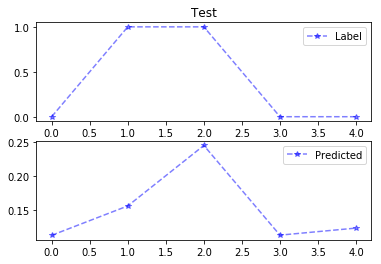

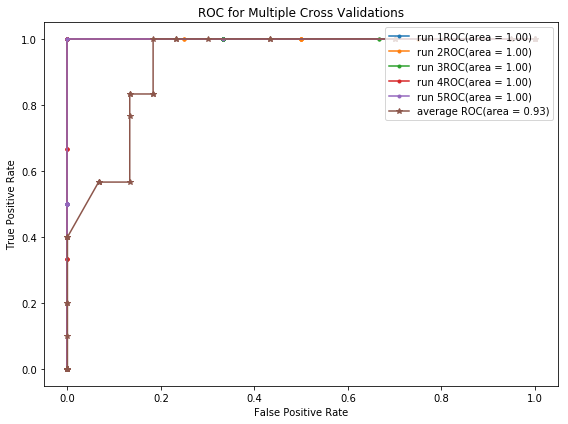

In [15]:
from glob import glob
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from glob import glob

files = glob(('/content/drive/My Drive/detection/data/*/*.bmp'))

y = [0 if f.split('/')[6] == 'ok' else 1 for f in files]
num_cross_valids = 5
# 存储每一个交叉验证运行时产生的结果
roc_df = []
result = []
# files[:5]
#do N-fold cross validation
for i in range(0,num_cross_valids):    
    #separate into 70% train, 30% test
    X_train, X_test, y_train, y_test = train_test_split(files, y,test_size=0.1)
    model, roc_temp = train_model_with_test_data(X_train, y_train, X_test, y_test, i, do_plot=True)
    roc_df.append(roc_temp)

#plot the ROC curves
roc_avg = plot_roc(roc_df)


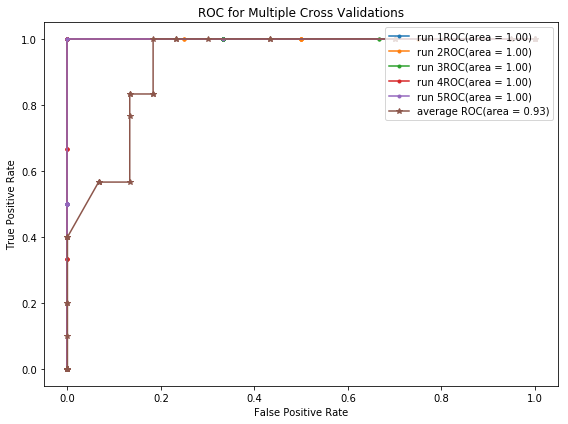

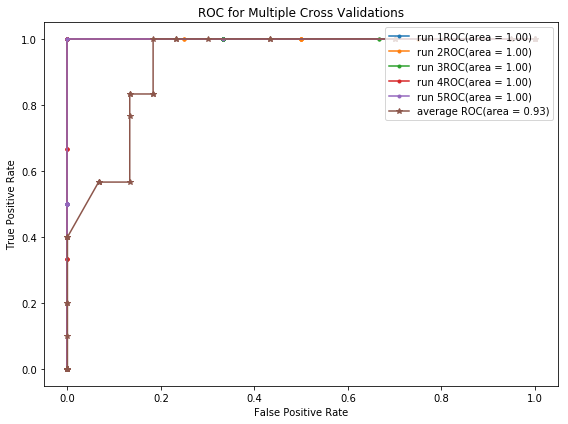

In [16]:
# roc_avg = plot_roc(roc_df)
roc_avg = plot_roc(roc_df)

调整了学习率之后，从64e-5调整到64e-4过程后，收敛速度变快，使得正确率（0.5为阈值）在0.5以上。

将训练样本的规模从0.7变为0.9，样本量增大后，正确率达到了较好地结果，样本规模变好之后，基于数据学习的模型效果更好。

数据量和学习率很重要。

拼图的数据尺寸为270*246之后，较织物数据、涡轮数据相比，织物数据、涡轮轴芯数据尺寸较小，因此检测出实际环境下的缺陷位置，缺陷在原来模型基础上较为微弱，而微弱的缺陷在较小的特征图中效果可能较差，而在较大的特征图中效果确实较好。

拼图数据的缺陷检测，是对大块图像进行检测，检测过程中检测的特征图如果较大的话，不利于GLobalMaxPooling这个函数的作用，因此将特征图缩小，可能效果会比较好。